# Clustering Sc-10x data

Please refer to:
file:///Users/waynewu/4.Github/Clustering-for-scRNAseq/dataset/sc-10x/web_summary.html

n_obs: number of cells <br>
n_vars: number of features

### adata:
n_obs x n_vars
1. use indexing and .X to get data. 
   
   Ex. 
       adata[:, meta].X, 
       adata.obs['n_genes']
       adata.var['n_features']
2. matrix.A1: transform to ndarray

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


# Start

In [58]:
# Read in th data
import os
path = '/Users/waynewu/4.Github/Clustering-for-scRNAseq/dataset/subsampling-5c/'
adata = sc.read_10x_mtx(
    os.path.join(path, '50/filtered_feature_bc_matrix'),  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)     

... writing an h5ad cache file to speedup reading next time


In [59]:
adata

View of AnnData object with n_obs × n_vars = 4340 × 33538 
    var: 'gene_ids', 'feature_types'

# Preprocessing the data

### 1. Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


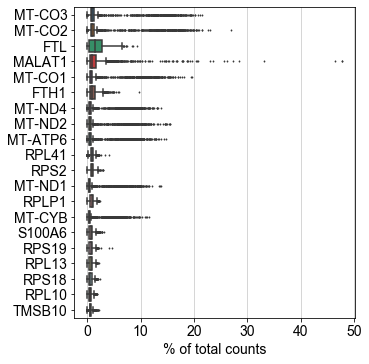

In [60]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [61]:
# Filter out cells with less than 200 genes and genes that are detected less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 199 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 14719 genes that are detectedin less than 3 cells


### 2. Quality Control of mitochondrial genes
High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [62]:
# Get the MI percentage of each cell
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


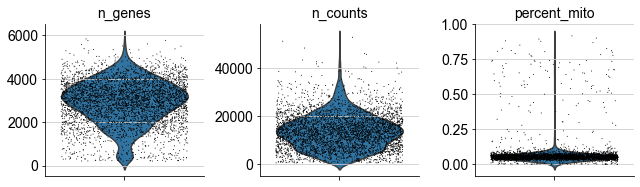

In [63]:
# Computed quality measures
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

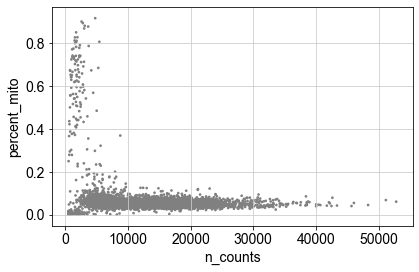

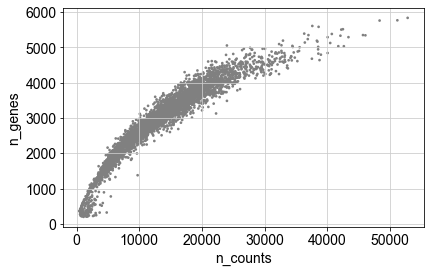

In [64]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [65]:
# Do the filtering
adata = adata[adata.obs['n_genes'] > 1000, :] #1000
adata = adata[adata.obs['n_genes'] < 6000, :] #7000
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [66]:
# Normalize total counts to 10,000 reads per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logarithmic the data
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [67]:
adata.raw = adata

### 3. Identify highly-variable genes

In [68]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


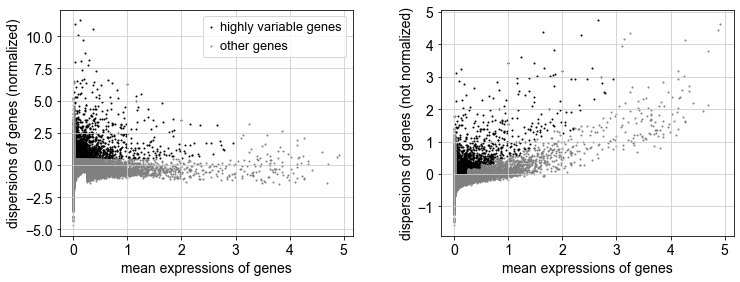

In [69]:
sc.pl.highly_variable_genes(adata)

In [70]:
adata = adata[:, adata.var['highly_variable']]

In [71]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:18)


# Run PCA and embed the graph

### 1. PCA

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


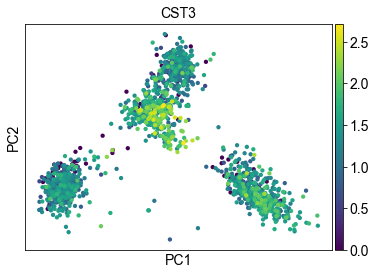

In [72]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

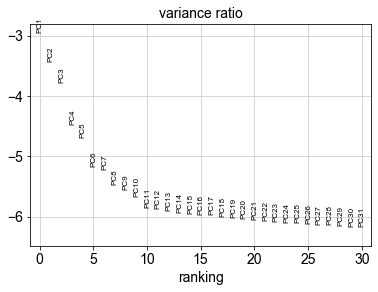

In [73]:
sc.pl.pca_variance_ratio(adata, log=True)

### 2. Compute the neighborhood graph and embed it

In [74]:
# Calculate the neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# use UMAP to embed the graph
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


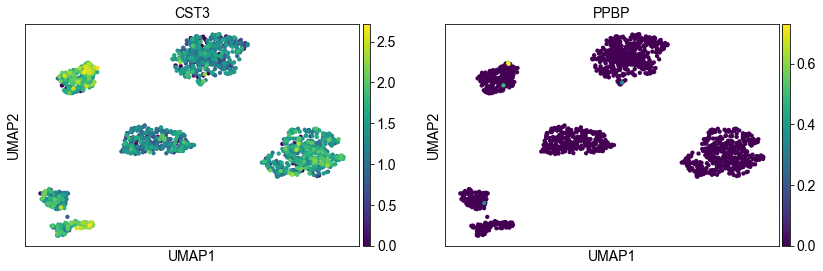

In [75]:
sc.pl.umap(adata, color=['CST3', 'PPBP'])

# Clustering the neighborhood graph

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


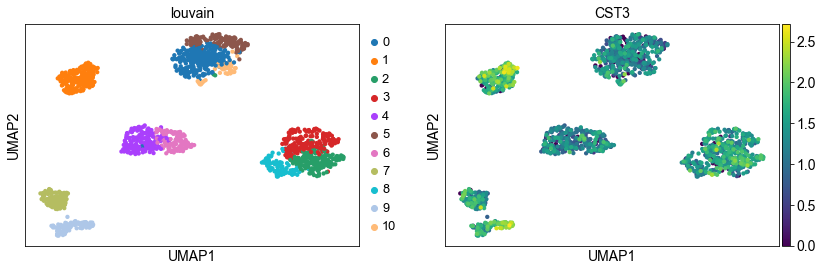

In [76]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain', 'CST3'], show=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


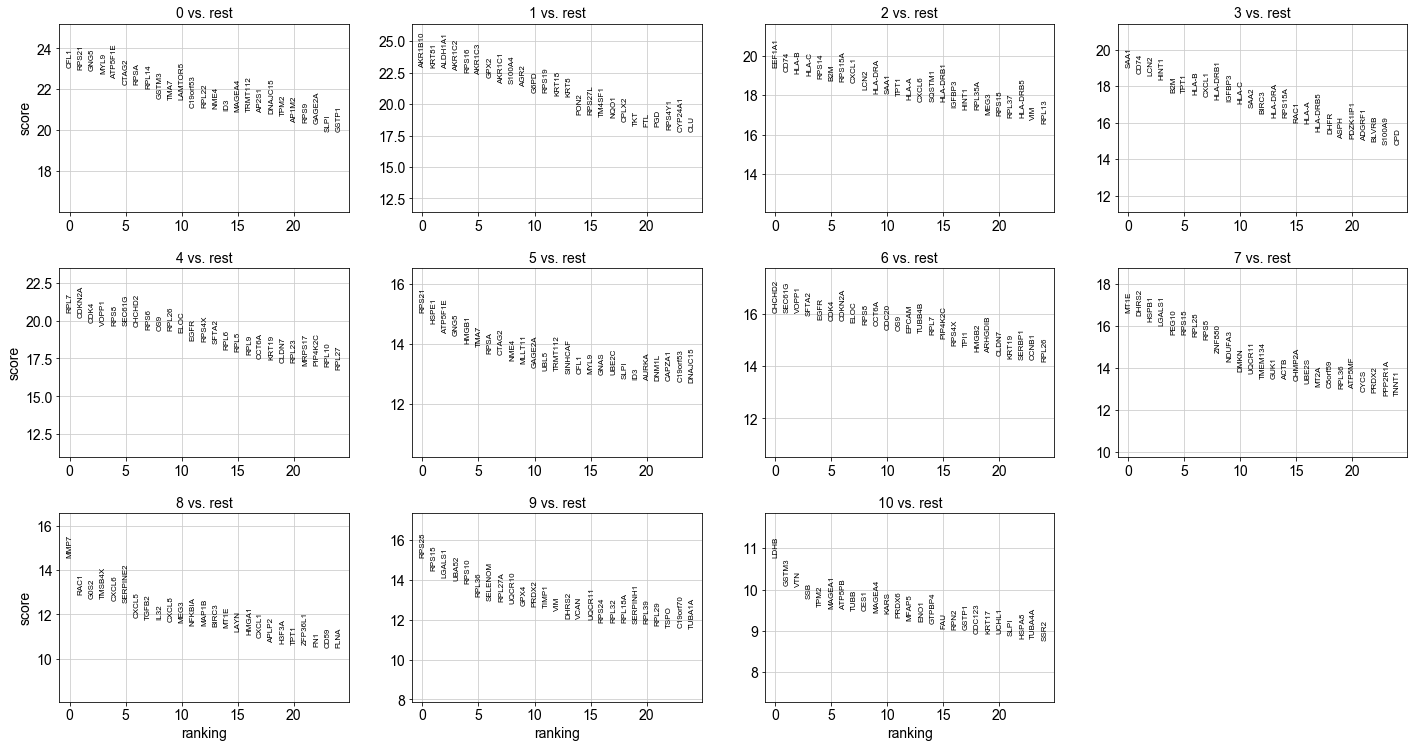

In [77]:
# Find the remarkable genes
# method: t-test, wilcoxon, logreg
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [78]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,CFL1,AKR1B10,EEF1A1,SAA1,RPL7,RPS21,CHCHD2,MT1E,MMP7,RPS28,LDHB
1,RPS21,KRT81,CD74,CD74,CDKN2A,HSPE1,SEC61G,DHRS2,RAC1,RPS15,GSTM3
2,GNG5,ALDH1A1,HLA-B,LCN2,CDK4,ATP5F1E,VOPP1,HSPB1,G0S2,LGALS1,VTN
3,MYL9,AKR1C2,HLA-C,HINT1,VOPP1,GNG5,SFTA2,LGALS1,TMSB4X,UBA52,SSB
4,ATP5F1E,RPS16,RPS14,B2M,RPS8,HMGB1,EGFR,PEG10,CXCL6,RPS10,TPM2


In [79]:
# Get a table with the scores and groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p
0,CFL1,5.860427e-118,AKR1B10,1.652107e-116,EEF1A1,5.257037e-84,SAA1,6.489154e-81,RPL7,5.708523e-94,...,CHCHD2,3.328502e-58,MT1E,2.053735e-62,MMP7,2.721699e-48,RPS28,8.568344e-52,LDHB,3.903661e-27
1,RPS21,4.879199e-117,KRT81,2.965041e-116,CD74,2.751258e-82,CD74,5.175988e-78,CDKN2A,8.649959e-91,...,SEC61G,3.905161e-58,DHRS2,4.432400e-61,RAC1,3.388214e-38,RPS15,1.777516e-47,GSTM3,5.396344e-24
2,GNG5,2.840397e-116,ALDH1A1,3.095923e-115,HLA-B,2.865543e-81,LCN2,3.315023e-77,CDK4,9.183564e-88,...,VOPP1,3.995290e-58,HSPB1,4.850216e-59,G0S2,3.276863e-37,LGALS1,4.293994e-45,VTN,7.652647e-24
3,MYL9,5.231959e-115,AKR1C2,4.119568e-114,HLA-C,2.104296e-80,HINT1,2.065849e-75,VOPP1,3.242635e-86,...,SFTA2,2.653531e-57,LGALS1,6.829975e-58,TMSB4X,4.172043e-37,UBA52,3.468469e-44,SSB,1.318179e-22
4,ATP5F1E,1.596187e-112,RPS16,5.268728e-112,RPS14,5.039186e-79,B2M,6.518808e-70,RPS8,3.572642e-86,...,EGFR,3.280639e-56,PEG10,4.929731e-55,CXCL6,1.617335e-36,RPS10,2.039030e-43,TPM2,8.810451e-22


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


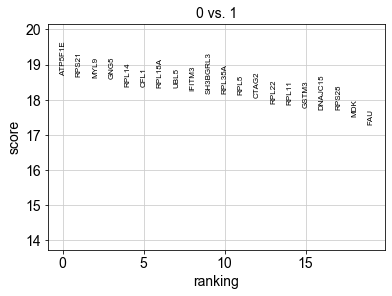

In [80]:
# Compare to a single cluster
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [81]:
adata

AnnData object with n_obs × n_vars = 1620 × 2907 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Store cluster results and ground truth

In [82]:
data = adata.obs.reset_index()

In [83]:
data["barcode"] = data[0]
data.pop(0)
data["barcode"] = data["barcode"].map(lambda x: x[:-2])
data.head(10)

,n_genes,percent_mito,n_counts,louvain,barcode
0,3754,0.041844,21843.0,9,AAACCTGAGAGACTAT
1,4220,0.048269,24902.0,2,AAACCTGGTCTAACGT
2,4216,0.037175,23161.0,2,AAACCTGTCCGCGCAA
3,4792,0.027221,27626.0,7,AAACCTGTCCTTTCTC
4,3070,0.047445,13953.0,1,AAACCTGTCTGCCCTA
5,3908,0.038800,20361.0,0,AAACGGGAGACTGGGT
6,3051,0.044368,11923.0,0,AAAGATGAGCAATATG
7,3316,0.046397,15195.0,2,AAAGATGCAAGGGTCA
8,3420,0.049278,18690.0,4,AAAGATGCACGCTTTC
9,3806,0.034284,17880.0,8,AAAGCAAAGATCGATA


In [56]:
newdata = table.merge(data, on='barcode_sequence')
newdata.head(10)

NameError: name 'table' is not defined

In [29]:
newdata['target'] = newdata['cell_line_demuxlet'].factorize()[0]
newdata.head(10)

NameError: name 'newdata' is not defined

In [84]:
data[["barcode", "louvain"]].to_csv('/Users/waynewu/4.Github/Clustering-for-scRNAseq/cluster_results/subsampling-5c/50/seurat-python.csv')
